In [1]:
import os
import urllib.request

import matplotlib.pyplot as plt

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## clustering


In [2]:
import numpy as np

In [3]:
blob_centers = np.array(
    [[0.2, 2.3], [-1.5, 2.3], [-2.8, 1.8], [-2.8, 2.8], [-2.8, 1.3]]
)
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

In [4]:
from sklearn.datasets import make_blobs

X, y = make_blobs(
    n_samples=2000, centers=blob_centers, cluster_std=blob_std, random_state=7
)

In [5]:
# K-mean
from sklearn.cluster import KMeans

k = 5
kmeans = KMeans(n_clusters=k)
y_pred = kmeans.fit_predict(X)

In [6]:
y_pred

array([0, 0, 4, ..., 2, 1, 0], shape=(2000,), dtype=int32)

In [7]:
y_pred is kmeans.labels_

True

In [8]:
kmeans.cluster_centers_

array([[-2.80214068,  1.55162671],
       [ 0.05253861,  2.57990378],
       [-2.79290307,  2.79641063],
       [-1.47083264,  2.28276928],
       [ 0.3329687 ,  1.98658932]])

In [9]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([4, 4, 2, 2], dtype=int32)

In [10]:
kmeans.transform(X_new)

array([[2.83778629, 0.58227889, 2.9042344 , 1.49776738, 0.33323866],
       [5.81943941, 3.00396688, 5.84739223, 4.47976595, 2.66706501],
       [1.4618254 , 3.08131024, 0.29040966, 1.68901531, 3.48363052],
       [0.96879317, 3.05358422, 0.36159148, 1.54451999, 3.37227978]])

In [11]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=5)
minibatch_kmeans.fit(X)

,n_clusters,5
,init,'k-means++'
,max_iter,100
,batch_size,1024
,verbose,0
,compute_labels,True
,random_state,None
,tol,0.0
,max_no_improvement,10
,init_size,None
,n_init,'auto'


In [12]:
from sklearn.metrics import silhouette_score

silhouette_score(X, kmeans.labels_)

0.63495890957226

## image segmentation


In [13]:
# Download the ladybug image
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "unsupervised_learning")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "ladybug.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/unsupervised_learning/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('.\\images\\unsupervised_learning\\ladybug.png',
 <http.client.HTTPMessage at 0x237abb2abc0>)

In [14]:
import os

from matplotlib.image import imread

image = imread(os.path.join("images", "clustering", "ladybug.png"))

In [15]:
image.shape

(533, 800, 3)

In [16]:
X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=8).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

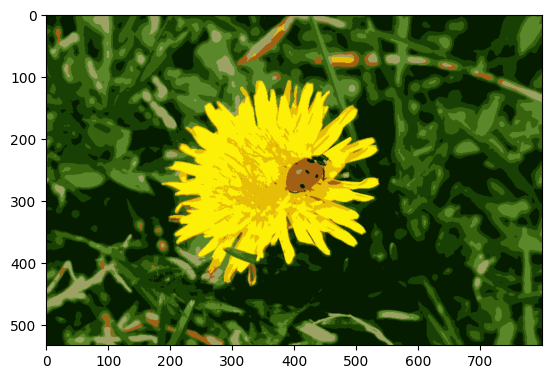

In [17]:
plt.imshow(segmented_img)
plt.show()

## clustering for preprocessing


In [18]:
from sklearn.datasets import load_digits

X_digits, y_digits = load_digits(return_X_y=True)

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits)

In [29]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(random_state=42, max_iter=500)
log_reg.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,500
,multi_class,'deprecated'


In [30]:
log_reg.score(X_test, y_test)

0.9644444444444444

In [36]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.pipeline import Pipeline

pipeline = Pipeline(
    [
        ("kmeans", KMeans(n_clusters=50)),
        ("scaler", StandardScaler()),
        ("log_reg", LogisticRegression(max_iter=1000)),
    ]
)
pipeline.fit(X_train, y_train)

,steps,"[('kmeans', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,n_clusters,50
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,None


In [37]:
pipeline.score(X_test, y_test)

0.9733333333333334

In [40]:
from sklearn.model_selection import GridSearchCV

param_grid = dict(kmeans__n_clusters=range(2, 100))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=1)
_ = grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 98 candidates, totalling 294 fits


In [41]:
grid_clf.best_params_

{'kmeans__n_clusters': 86}

In [ ]:
grid_clf.score(X_test, y_test)

0.9755555555555555

## semi-supervised


In [ ]:
n_labeled = 50
log_reg = LogisticRegression()
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [ ]:
log_reg.score(X_test, y_test)

0.8222222222222222

In [ ]:
k = 50
kmeans = KMeans(n_clusters=k)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]
y_representative_digits = y_train[representative_digit_idx]

In [ ]:
log_reg = LogisticRegression()
log_reg.fit(X_representative_digits, y_representative_digits)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [48]:
log_reg.score(X_test, y_test)

0.9066666666666666

## label propagation


In [49]:
y_train_propergated = np.empty(len(X_train), dtype=np.int32)
for i in range(k):
    y_train_propergated[kmeans.labels_ == i] = y_representative_digits[i]

In [50]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train_propergated)
log_reg.score(X_test, y_test)

d:\software\anaconda\envs\AI-related\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9288888888888889

In [51]:
percentile_closest = 20
X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = kmeans.labels_ == i
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = X_cluster_dist > cutoff_distance
    X_cluster_dist[in_cluster & above_cutoff] = -1

partially_propagated = X_cluster_dist != -1
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propergated[partially_propagated]

In [52]:
log_reg = LogisticRegression()
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)
log_reg.score(X_test, y_test)

0.9222222222222223

In [53]:
np.mean(y_train_partially_propagated == y_train[partially_propagated])


np.float64(0.9896551724137931)

## DBSCAN


In [6]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, noise=0.05)
dbscan = DBSCAN(eps=0.2, min_samples=5)
dbscan.fit(X)

,eps,0.2
,min_samples,5
,metric,'euclidean'
,metric_params,None
,algorithm,'auto'
,leaf_size,30
,p,None
,n_jobs,None


In [7]:
dbscan.labels_

array([0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1,

In [8]:
len(dbscan.core_sample_indices_)

1000

In [9]:
dbscan.core_sample_indices_

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [10]:
dbscan.components_

array([[-0.21889122,  0.94170996],
       [-0.7311019 ,  0.70323068],
       [-0.9665687 ,  0.06794377],
       ...,
       [ 0.92537591, -0.4469138 ],
       [-0.82741218,  0.4817826 ],
       [ 1.2052294 , -0.37215231]], shape=(1000, 2))

In [11]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

,n_neighbors,50
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [ ]:
import numpy as np

X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
knn.predict(X_new)

array([0, 1, 0, 1])

In [14]:
knn.predict_proba(X_new)

array([[0.9 , 0.1 ],
       [0.  , 1.  ],
       [0.74, 0.26],
       [0.  , 1.  ]])

In [ ]:
y_dist, y_pred_idx = knn.kneighbors(X_new, n_neighbors=1)
y_pred = dbscan.labels_[dbscan.core_sample_indices_][y_pred_idx]
y_pred[y_dist > 0.2] = -1
y_pred.ravel()

array([-1,  1,  0, -1])

## gaussian mixture


In [ ]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=3, n_init=10)
gm.fit(X)

,n_components,3
,covariance_type,'full'
,tol,0.001
,reg_covar,1e-06
,max_iter,100
,n_init,10
,init_params,'kmeans'
,weights_init,None
,means_init,None
,precisions_init,None
,random_state,None


In [17]:
gm.weights_

array([0.19006161, 0.62288837, 0.18705002])

In [18]:
gm.means_


array([[-0.77262221,  0.5354109 ],
       [ 0.50533702,  0.24550914],
       [ 1.78193314, -0.03196694]])

In [19]:
gm.covariances_

array([[[ 0.04043654,  0.05221073],
        [ 0.05221073,  0.08123615]],

       [[ 0.19528992, -0.12378566],
        [-0.12378566,  0.29779667]],

       [[ 0.03706467,  0.04952168],
        [ 0.04952168,  0.080648  ]]])

In [20]:
gm.converged_

True

In [21]:
gm.predict(X)

array([1, 0, 0, 1, 1, 1, 2, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 0, 1, 2,
       1, 1, 2, 1, 1, 2, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 2, 1, 1, 2, 0, 1, 1, 2, 0, 2, 1, 1, 2, 2, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 2, 0,
       1, 0, 0, 2, 1, 2, 1, 0, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 2, 2, 0, 1, 1, 0, 1, 1, 2, 2, 1, 1, 2, 1,
       2, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 1, 0, 2, 0,
       1, 1, 2, 2, 1, 0, 2, 1, 1, 1, 0, 1, 2, 1, 0, 1, 1, 2, 2, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 2, 2, 0, 1, 1, 1, 2, 0, 1, 1, 1, 2, 1, 0,
       1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 2, 2, 1,
       1, 0, 1, 2, 1, 0, 0, 1, 2, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 2, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 2, 1, 1, 0, 1, 2, 0, 1, 1, 1, 2, 0, 1,

In [22]:
gm.predict_proba(X)

array([[8.29293240e-003, 9.91707068e-001, 1.55212933e-222],
       [9.90489099e-001, 9.51090106e-003, 1.12327591e-288],
       [9.99232565e-001, 7.67435338e-004, 2.18863115e-257],
       ...,
       [9.68784741e-174, 1.00000000e+000, 3.36678039e-012],
       [9.98214915e-001, 1.78508499e-003, 1.68614759e-280],
       [6.10132332e-209, 9.99810378e-001, 1.89622263e-004]],
      shape=(1000, 3))

In [ ]:
X_new, y_new = gm.sample(6)
X_new

array([[-0.6271963 ,  0.68651826],
       [-0.35258054,  0.63097625],
       [ 1.54452316, -0.14438843],
       [ 1.5298292 , -0.30195053],
       [ 0.43976463,  0.06434995],
       [ 0.59707208,  0.62001054]])

## anomaly detection


In [24]:
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 4)
anomalies = X[densities < density_threshold]

## select the number of clusters


In [25]:
gm.bic(X)

np.float64(2733.399202332446)

In [26]:
gm.aic(X)

np.float64(2649.9673625897494)

## bayesian gaussian mixture models


In [28]:
from sklearn.mixture import BayesianGaussianMixture

bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X)
np.round(bgm.weights_, 2)

array([0.07, 0.14, 0.16, 0.14, 0.2 , 0.17, 0.12, 0.  , 0.  , 0.  ])